In [1]:
# ==========================
# 1. Import Libraries
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
# ==========================
# 2. Load Dataset
# ==========================
df = pd.read_csv("uber.csv")   # Change path if needed
print(df.head())
print(df.info())


   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
         Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  1.999990e+05  199999.000000     199999.000000    199999.000000   
mean   2.771248e+07      11.359892        -72.527631        39.935881   
std    1.601386e+07       9.901760         11.437815         7.720558   
min    1.000000e+00     -52.000000      -1340.648410       -74.015515   
25%    1.382534e+07       6.000000        -73.992065        40.734796   
50%    2.774524e+07       8.500000        -73.981823        40.752592   
75%    4.155535e+07      12.500000        -73.967154        40.767158   
max    5.542357e+07     499.000000         57.418457      1644.421482   

       dropoff_longitude  dropoff_latitude  passenger_count  
count      199999.000000     199999.000000    199999.000000 

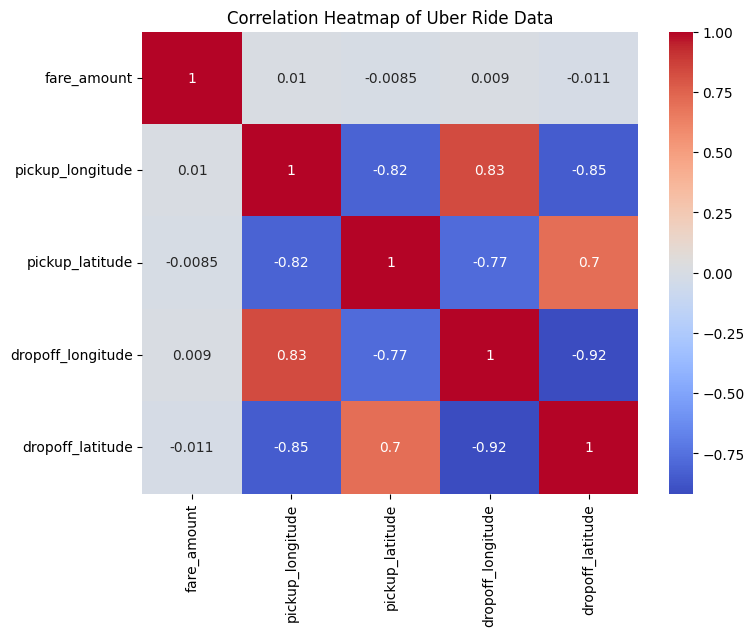

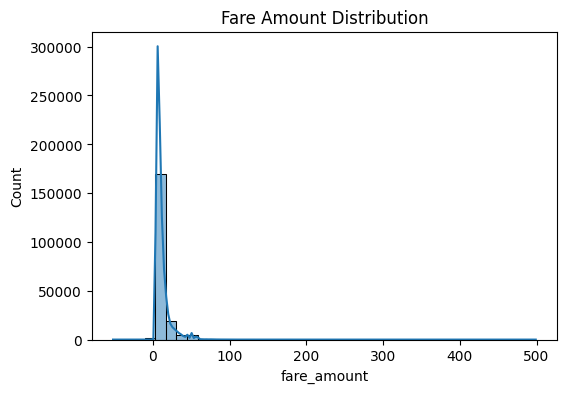

In [5]:
# ==========================
# 3. Exploratory Data Analysis (EDA)
# ==========================

# Check missing values
print(df.isnull().sum())

# Drop missing values
df = df.dropna()

# Summary statistics
print(df.describe())

# --- Heatmap for multiple columns ---
plt.figure(figsize=(8,6))
cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude']
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Uber Ride Data")
plt.show()

# Distribution of fare amount
plt.figure(figsize=(6,4))
sns.histplot(df['fare_amount'], bins=40, kde=True)
plt.title("Fare Amount Distribution")
plt.show()


In [11]:
# ==========================
# 4. Data Cleaning & Feature Engineering (Simplified)
# ==========================

# Remove invalid fare values
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]

# Convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract time features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

# Calculate trip distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                              df['dropoff_latitude'], df['dropoff_longitude'])

# Keep only useful columns
df = df[['fare_amount', 'distance_km', 'hour', 'day', 'month', 'year']]
print(df.head())


   fare_amount  distance_km  hour  day  month  year
0          7.5     1.683323    19    7      5  2015
1          7.7     2.457590    20   17      7  2009
2         12.9     5.036377    21   24      8  2009
3          5.3     1.661683     8   26      6  2009
4         16.0     4.475450    17   28      8  2014


In [13]:
# ==========================
# 5. Train-Test Split
# ==========================
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# ==========================
# 6. Model WITHOUT PCA
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_no_pca = LinearRegression()
model_no_pca.fit(X_train_scaled, y_train)
y_pred_no_pca = model_no_pca.predict(X_test_scaled)

r2_no_pca = r2_score(y_test, y_pred_no_pca)
rmse_no_pca = np.sqrt(mean_squared_error(y_test, y_pred_no_pca))
mae_no_pca = mean_absolute_error(y_test, y_pred_no_pca)

print("Model WITHOUT PCA:")
print(f"R² Score: {r2_no_pca:.4f}")
print(f"RMSE: {rmse_no_pca:.4f}")
print(f"MAE: {mae_no_pca:.4f}")


Model WITHOUT PCA:
R² Score: 0.0173
RMSE: 9.2615
MAE: 5.8575


In [21]:
# ==========================
# 7. Model WITH PCA
# ==========================
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)

r2_pca = r2_score(y_test, y_pred_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
mae_pca = mean_absolute_error(y_test, y_pred_pca)

print("\nModel WITH PCA:")
print(f"R² Score: {r2_pca:.4f}")
print(f"RMSE: {rmse_pca:.4f}")
print(f"MAE: {mae_pca:.4f}")



Model WITH PCA:
R² Score: 0.0056
RMSE: 9.3165
MAE: 5.9055



Model Performance Comparison:
         Model  R² Score      RMSE       MAE
0  Without PCA  0.017316  9.261526  5.857499
1     With PCA  0.005618  9.316490  5.905470


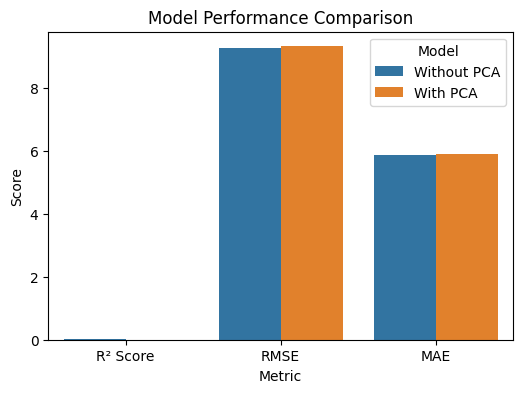

In [23]:
# ==========================
# 8. Compare Both Models
# ==========================
results = pd.DataFrame({
    'Model': ['Without PCA', 'With PCA'],
    'R² Score': [r2_no_pca, r2_pca],
    'RMSE': [rmse_no_pca, rmse_pca],
    'MAE': [mae_no_pca, mae_pca]
})
print("\nModel Performance Comparison:")
print(results)

# Visual comparison
plt.figure(figsize=(6,4))
sns.barplot(data=results.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Metric', y='Score', hue='Model')
plt.title("Model Performance Comparison")
plt.show()
